<a href="https://colab.research.google.com/github/Aiden-Ross-Dsouza/Generative-Models/blob/main/Generative%20Adversarial%20Networks/notebooks/Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries

In [ ]:
import os
import shutil
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Download Dataset

In [ ]:
# Create Kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Define source and destination paths
source = "/content/drive/MyDrive/Kaggle_API/kaggle.json"
destination = "/root/.kaggle/kaggle.json"

# Copy the file
shutil.copy(source, destination)

# Set correct permissions
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d zalando-research/fashionmnist

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
 70% 48.0M/68.8M [00:00<00:00, 127MB/s]
100% 68.8M/68.8M [00:00<00:00, 146MB/s]


In [ ]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile("fashionmnist.zip", 'r') as zip_ref:
    zip_ref.extractall("fashion_mnist")

# List extracted files
!ls fashion_mnist

fashion-mnist_test.csv	 t10k-images-idx3-ubyte  train-images-idx3-ubyte
fashion-mnist_train.csv  t10k-labels-idx1-ubyte  train-labels-idx1-ubyte


# Dataset

In [ ]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('/content/fashion_mnist/fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
dataset = FashionMNIST()
dataset[0][0]
print(np.array(dataset[0][0]).shape)

(28, 28)


In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
])

dataset = FashionMNIST(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data.item()

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))

    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data.item()

Starting epoch 0...
g_loss: 4.308540344238281, d_loss: 0.28672072291374207


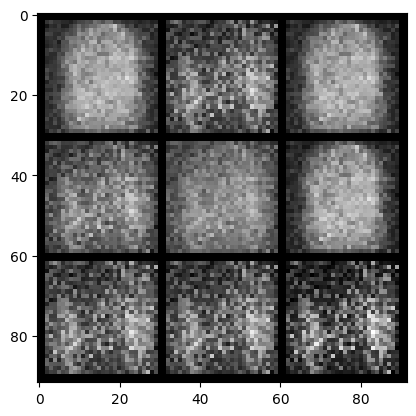

Starting epoch 1...
g_loss: 3.1108155250549316, d_loss: 0.20995157957077026


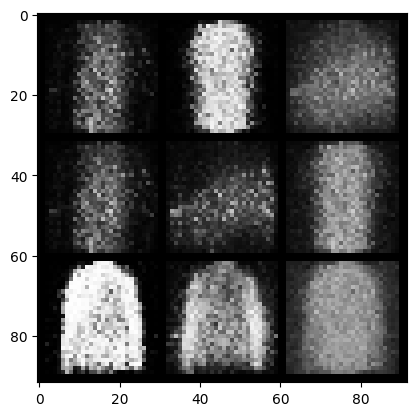

Starting epoch 2...
g_loss: 3.594226837158203, d_loss: 0.474235475063324


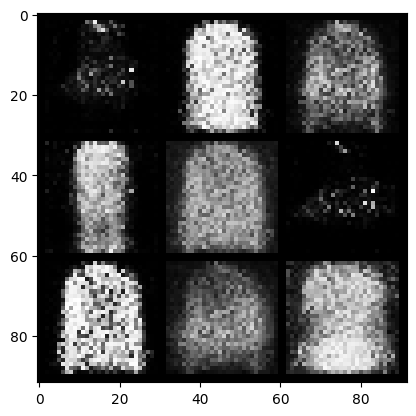

Starting epoch 3...
g_loss: 2.5765867233276367, d_loss: 0.2882782816886902


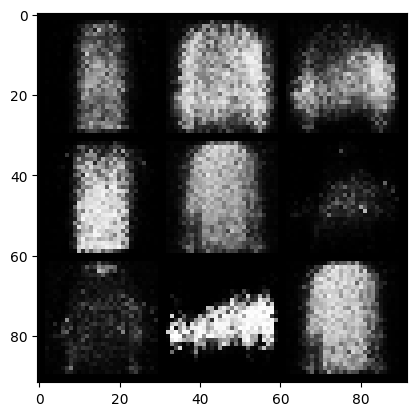

Starting epoch 4...
g_loss: 2.8983824253082275, d_loss: 0.8101227283477783


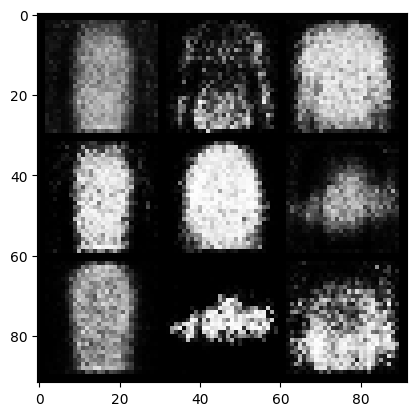

Starting epoch 5...
g_loss: 2.391162157058716, d_loss: 1.0562641620635986


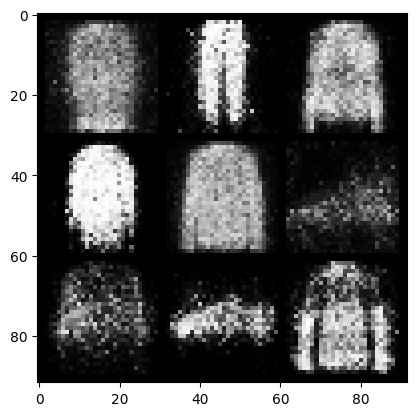

Starting epoch 6...
g_loss: 2.3739280700683594, d_loss: 0.5964943766593933


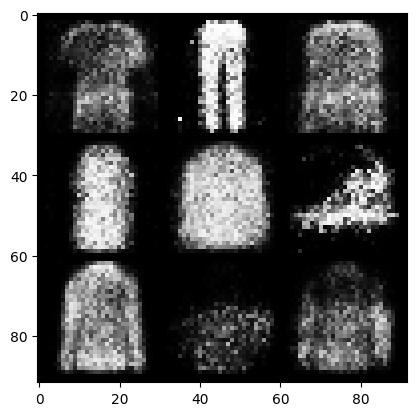

Starting epoch 7...
g_loss: 2.028451442718506, d_loss: 0.5921709537506104


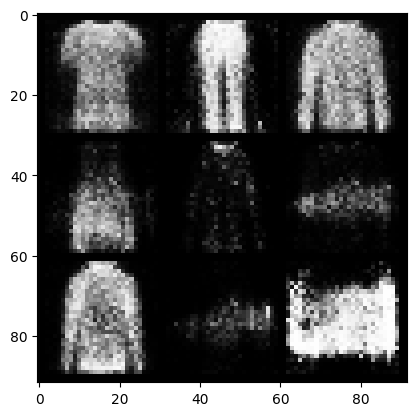

Starting epoch 8...
g_loss: 1.8218358755111694, d_loss: 0.6613537669181824


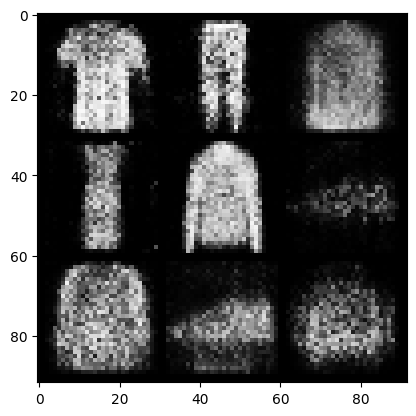

Starting epoch 9...
g_loss: 1.7889679670333862, d_loss: 1.2743895053863525


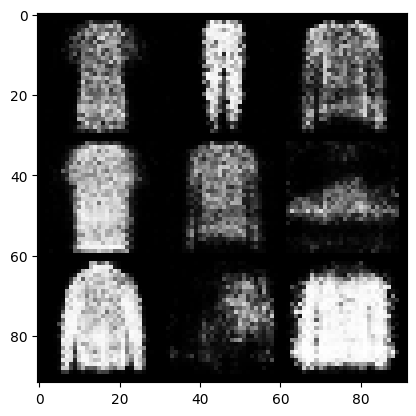

Starting epoch 10...
g_loss: 2.4062156677246094, d_loss: 0.9582539796829224


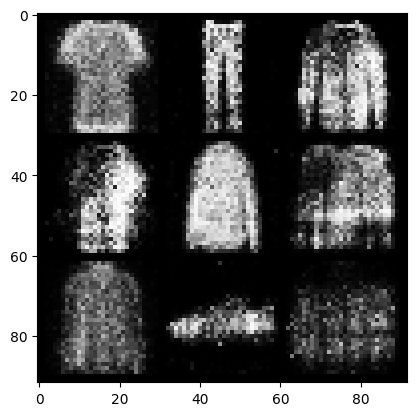

Starting epoch 11...
g_loss: 1.7256830930709839, d_loss: 0.593291699886322


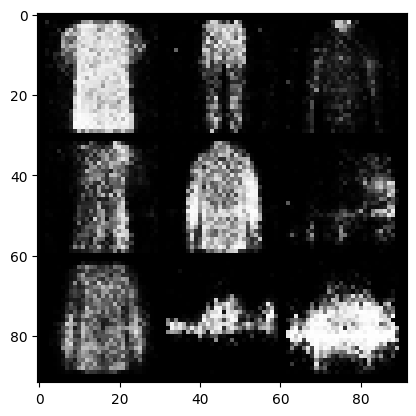

Starting epoch 12...
g_loss: 1.5058578252792358, d_loss: 0.6772081851959229


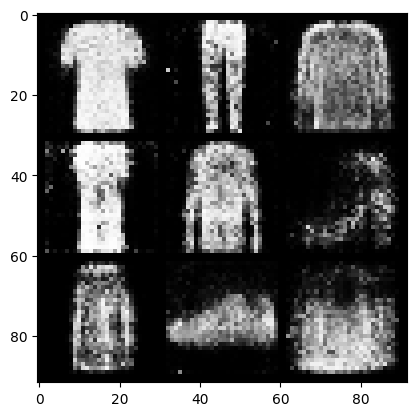

Starting epoch 13...
g_loss: 1.7085481882095337, d_loss: 0.8558353185653687


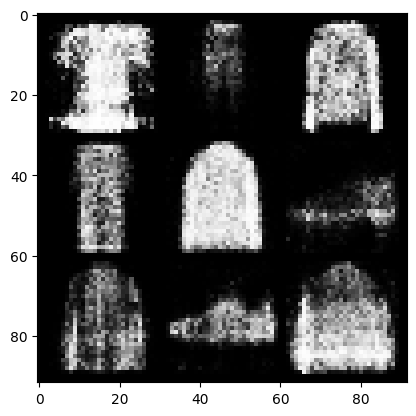

Starting epoch 14...
g_loss: 1.974971890449524, d_loss: 0.8858765363693237


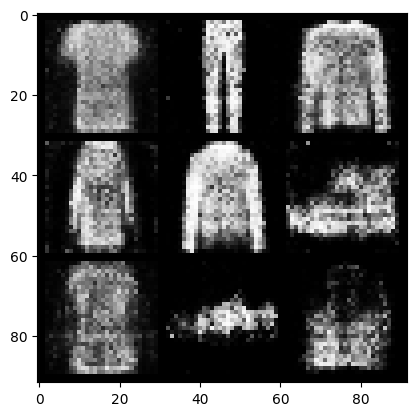

Starting epoch 15...
g_loss: 1.8245742321014404, d_loss: 0.8946966528892517


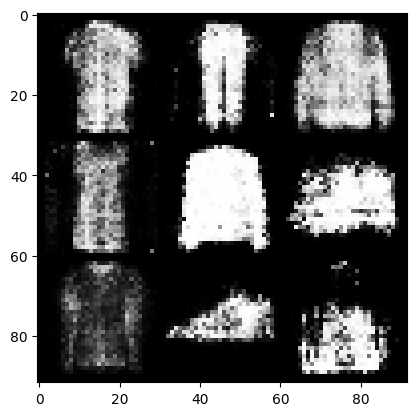

Starting epoch 16...
g_loss: 1.558117389678955, d_loss: 0.7820727825164795


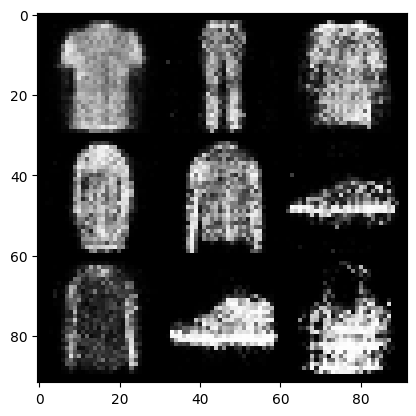

Starting epoch 17...
g_loss: 1.3217430114746094, d_loss: 0.6485520601272583


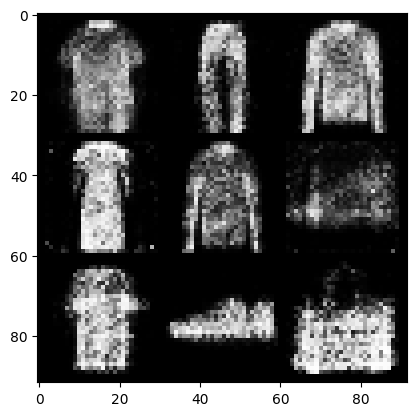

Starting epoch 18...
g_loss: 1.0415618419647217, d_loss: 1.3003175258636475


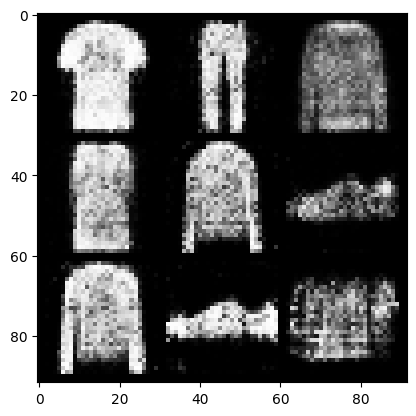

Starting epoch 19...
g_loss: 1.3522411584854126, d_loss: 1.1425542831420898


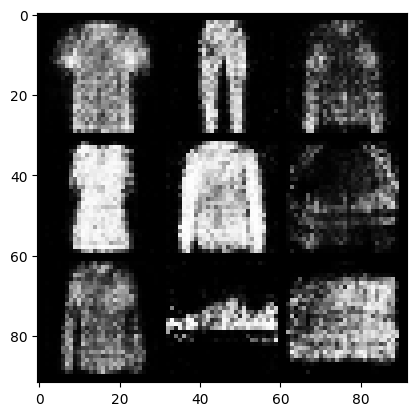

Starting epoch 20...
g_loss: 1.2779209613800049, d_loss: 0.9638667702674866


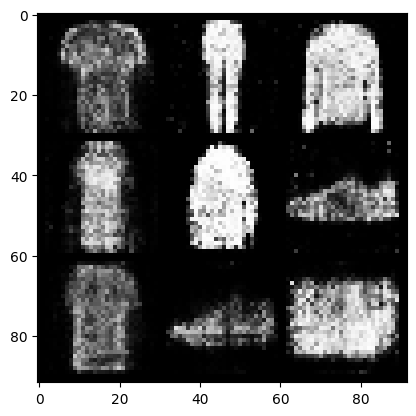

Starting epoch 21...
g_loss: 1.3800262212753296, d_loss: 1.103554606437683


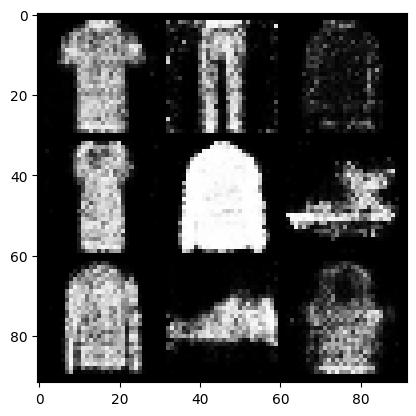

Starting epoch 22...
g_loss: 1.1947352886199951, d_loss: 1.3100039958953857


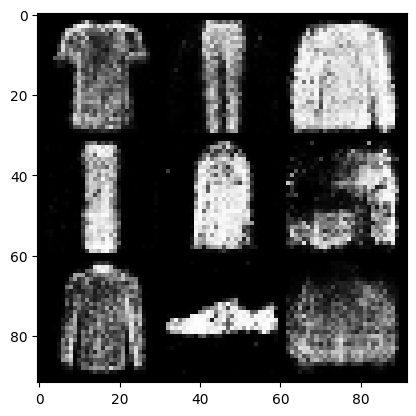

Starting epoch 23...
g_loss: 1.1275149583816528, d_loss: 1.127925157546997


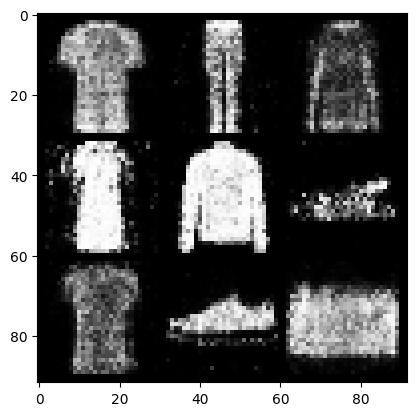

Starting epoch 24...
g_loss: 1.36300528049469, d_loss: 0.8205838799476624


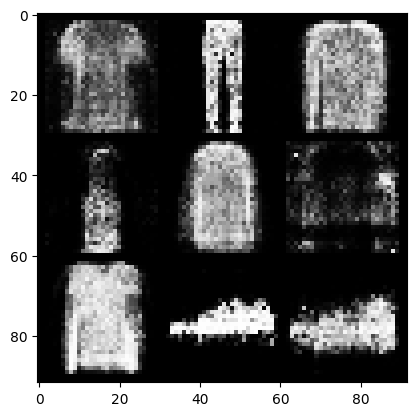

Starting epoch 25...
g_loss: 1.2162370681762695, d_loss: 1.1553280353546143


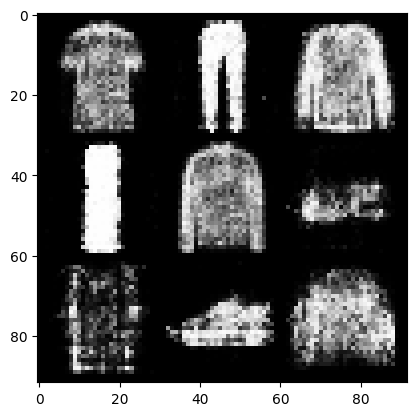

Starting epoch 26...
g_loss: 1.197177767753601, d_loss: 1.044478178024292


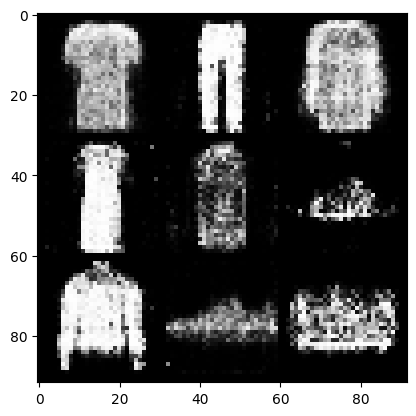

Starting epoch 27...
g_loss: 1.0536859035491943, d_loss: 0.8819838762283325


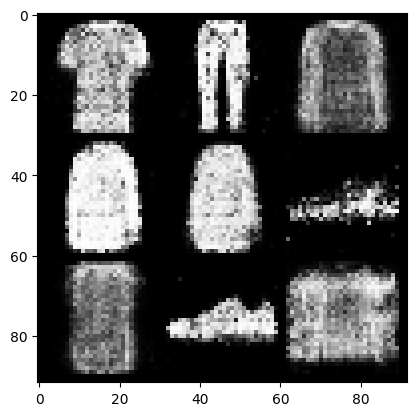

Starting epoch 28...
g_loss: 1.0527602434158325, d_loss: 1.2779231071472168


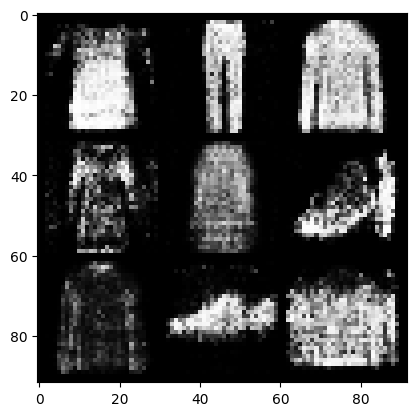

Starting epoch 29...
g_loss: 1.2606045007705688, d_loss: 1.17439603805542


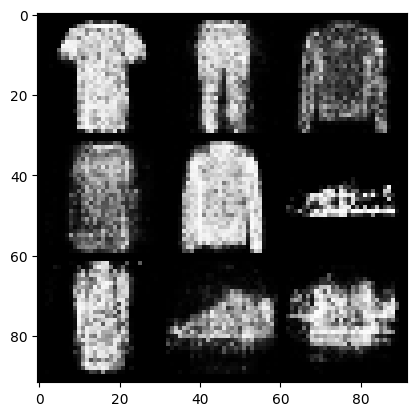

In [ ]:
num_epochs = 30
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).to(device)
    labels = Variable(torch.LongTensor(np.arange(9))).to(device)
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

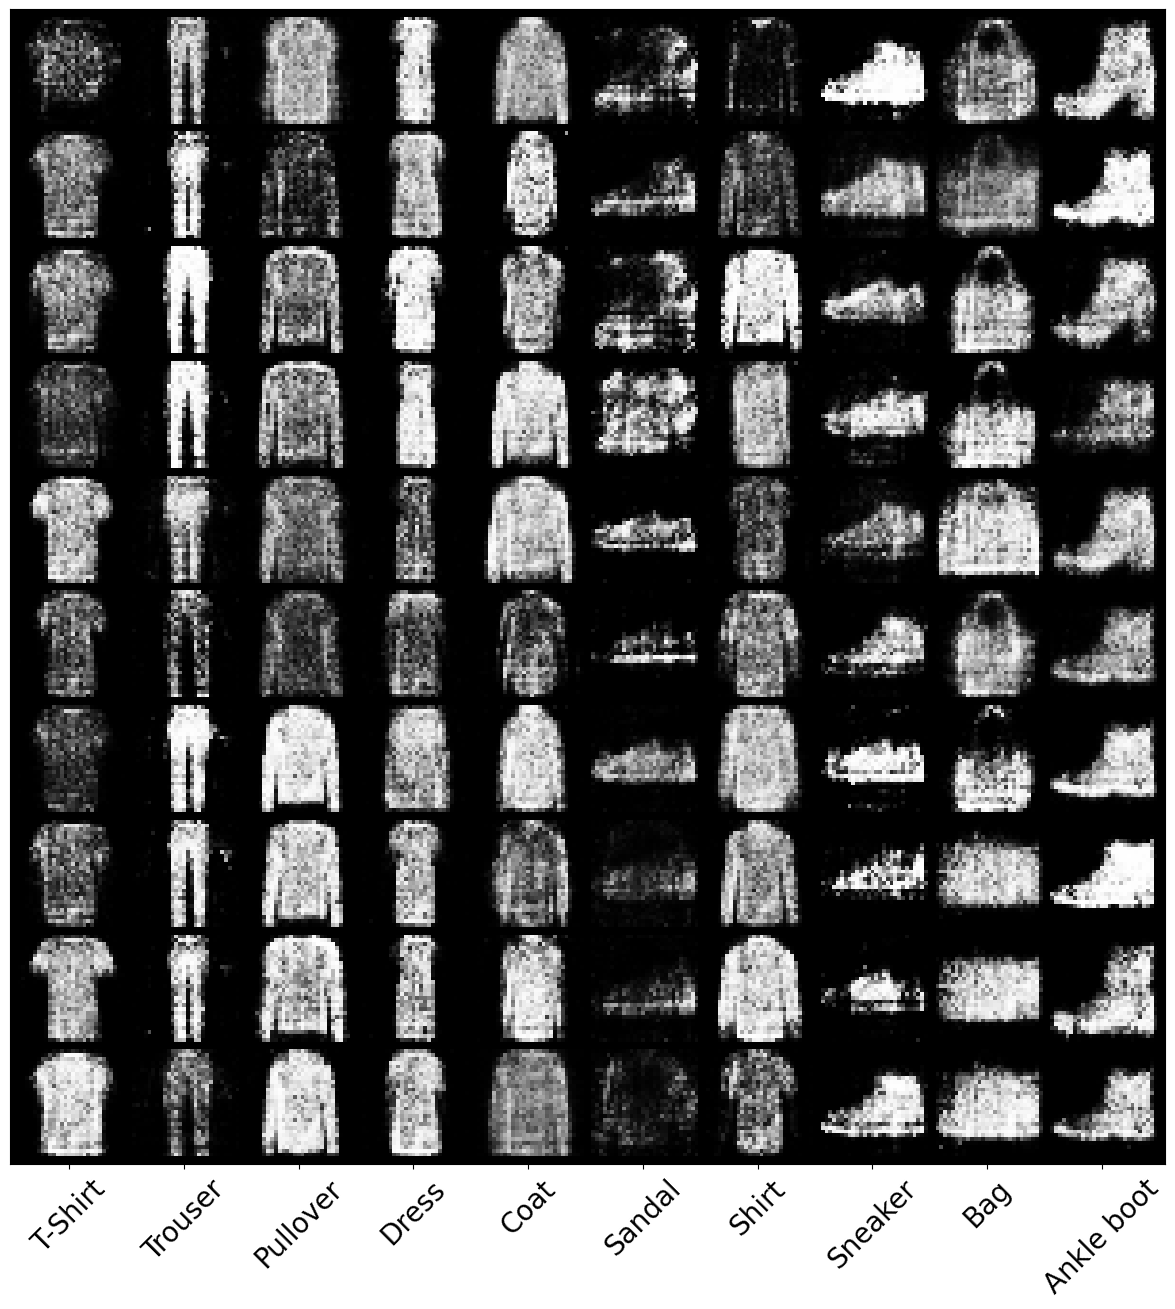

In [ ]:
z = Variable(torch.randn(100, 100)).to(device)
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).to(device)
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)